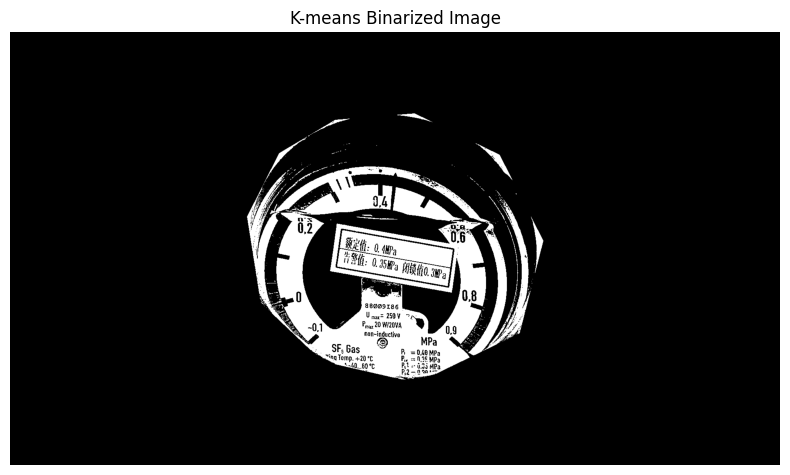

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def binarize_image(gray_image, threshold):
    """
    将灰度图像进行二值化处理，超过阈值的像素值设为255，小于阈值的设为0。

    参数:
    - gray_image: 输入的灰度图像 (2D numpy 数组)
    - threshold: 阈值，用于将像素分为两类

    返回:
    - 二值化后的图像
    """
    # 使用 numpy 的条件操作进行阈值化
    binary_image = np.where(gray_image > threshold, 255, 0).astype(np.uint8)

    return binary_image


# 读取图像
image = cv2.imread('../test.jpg', cv2.IMREAD_GRAYSCALE)
segmented_image = binarize_image(image, 67)


# 显示原始图像和二值化图像
plt.figure(figsize=(8, 8))
plt.title("K-means Binarized Image")
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
